In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



from datetime import datetime
from datetime import timedelta

from matplotlib import style
from matplotlib.dates import DateFormatter, AutoDateLocator

from scipy import stats

# from ipaddress import IPv4Address
from bidict import bidict
from dataclasses import dataclass

plt.rc('pgf', texsystem='pdflatex')

: 

In [ ]:
@dataclass(frozen=True)
class CommunicationPair:
    """ Representation of a communication pair.
    source -> destination
    ip:port -> ip:port
    """
    src_ip: str
    dst_ip: str

    src_port: int = None
    dst_port: int = None

In [ ]:
class DatasetCreator:

    def __init__(self, file_name: str):
        """Initialize a DatasetCreator instance and load data to dataframe from file.

        Parameters
        ----------
        file_name : str
            Path to csv file containing data.
        """
        self.file_name = file_name
        self.__load_data()
        self.__add_communication_id_columns()
        self.__add_relative_days()
        self.df = self.df.set_index(pd.DatetimeIndex(self.df['TimeStamp'])).drop(['TimeStamp'], axis=1)


    def __load_data(self) -> None:
        # todo robustnejsi pres nejaky DataSetLoader
        # todo df must have 'srcIP', 'srcPort', 'dstIP', 'dstPort', 'TimeStamp'
        # todo TimeStamp ve fromatu format="%H:%M:%S.%f"
        # todo check if file exists
        self.df = pd.read_csv(self.file_name, sep=";", dtype={'asduType':'category', 'numix':'category', 'cot':'category', 'uType':'category', 'oa':'category'}, parse_dates=['TimeStamp'])


    # def __convert_to_timeseries(self) -> None:
    #     time_series = pd.Series(a.TimeStamp.index, index=a.TimeStamp)
    #     ts = time_series.resample('30min').count()


    def __add_communication_id_columns(self) -> None:
        """Add L3 and L4 communication id columns to main dataframe
        """
        l3_pairs, l4_pairs = self.find_communication_pairs()

        self.df['l3comId'] = self.df.apply(lambda row: l3_pairs.inverse[CommunicationPair(row.srcIP, row.dstIP)], axis=1).astype("category")
        self.df['l4comId'] = self.df.apply(lambda row: l4_pairs.inverse[CommunicationPair(row.srcIP, row.dstIP, row.srcPort, row.dstPort)], axis=1).astype("category")


    def __add_relative_days(self) -> None:
        """Add a realtive day column and update DateTime column.

        The relative day will be added to the DateTime column.
        The date will be wrong, but it will reflect the relative time .

        """
        def find_relative_days() -> list:
            """Create a list of relative days in dataframe.

            Returns
            -------
            list
                Of format [0..0, 1..1, 2..2, 3..3, ...]
            """

            # edge cases
            if len(self.df.index) == 0:
                return []
            if len(self.df.index) == 1:
                return [0]

            # core of computation
            l = [0]
            counter = 0
            for i in range(1, len(self.df.index)):
                if self.df['TimeStamp'][i].time() < self.df['TimeStamp'][i-1].time():
                    counter += 1
                l.append(counter)
            return l

        self.df['relativeDay'] = find_relative_days()

        # add relative day to timestamp column
        self.df['TimeStamp'] = self.df.apply(lambda row: row.TimeStamp + timedelta(days=row.relativeDay), axis=1)    


    def find_communication_pairs(self) -> tuple[bidict[int, CommunicationPair], bidict[int, CommunicationPair]]:
        """Find L3 and L4 communication pairs.
        
        Identify all unique communicaion pairs in a dataframe and assign an id.

        L3: ip to ip
        L4: ip:port to ip:port

        Returns
        -------
        tuple[bidict[int, CommunicationPair], bidict[int, CommunicationPair]]
            [description]

            Two bidirectional dictionaries (L3 and L4)
            Key: id of communication pair
            Value: communication pair
        """
        
        tmp_l3_dict = dict()
        tmp_l4_dict = dict()
        i, j = 1, 1
        for (srcIP, srcPort, dstIP, dstPort) in zip(self.df.srcIP, self.df.srcPort, self.df.dstIP, self.df.dstPort):
            # L3
            if (srcIP, dstIP) not in tmp_l3_dict:
                tmp_l3_dict[(srcIP, dstIP)] = i
                i = i + 1
            
            # L4
            if (srcIP, srcPort, dstIP, dstPort) not in tmp_l4_dict:
                tmp_l4_dict[(srcIP, srcPort, dstIP, dstPort)] = j
                j = j + 1


        l4_communication_pairs = bidict()
        l3_communication_pairs = bidict()

        for key, value in tmp_l3_dict.items():
            l3_communication_pairs[value]  = CommunicationPair(key[0], key[1])

        for key, value in tmp_l4_dict.items():
            l4_communication_pairs[value]  = CommunicationPair(key[0], key[2], key[1], key[3])


        return l3_communication_pairs, l4_communication_pairs

In [ ]:
class DatasetAnalyser():
    
    def __init__(self, df: pd.DataFrame):
        self.original_df = df
        self.work_df = df.copy()  # deepcopy


    def convert(self):
        df = self.work_df

        for item in df.l3comId.unique():
            df[f"{df.l3comId.name}:{item}"] = df.apply(lambda row: True if row.l3comId == item else False, axis=1)

        for item in df.l4comId.unique():
            df[f"{df.l4comId.name}:{item}"] = df.apply(lambda row: True if row.l4comId == item else False, axis=1)

        for item in df.uType.unique().dropna():
            df[f"{df.uType.name}:{item}"] = df.apply(lambda row: True if row.uType == item else False, axis=1)

        for item in df.asduType.unique().dropna():
            df[f"{df.asduType.name}:{item}"] = df.apply(lambda row: True if row.asduType == item else False, axis=1)

        for item in df.numix.unique().dropna():
            df[f"{df.numix.name}:{item}"] = df.apply(lambda row: True if row.numix == item else False, axis=1)

        for item in df.cot.unique().dropna():
            df[f"{df.cot.name}:{item}"] = df.apply(lambda row: True if row.cot == item else False, axis=1)

        for item in df.oa.unique().dropna():
            df[f"{df.oa.name}:{item}"] = df.apply(lambda row: True if row.oa == item else False, axis=1)

        self.work_df = self.work_df.drop(['Relative Time', 'srcIP', 'dstIP', 'srcPort', 'dstPort', 'ipLen', 'len', 'fmt', 'uType', 'asduType', 'numix', 'cot', 'oa', 'addr', 'ioa', 'relativeDay', 'l3comId', 'l4comId'], axis=1)


    def resample(self):
        self.work_df = self.work_df.resample('1h').sum()
        

In [ ]:
datasetCreator = DatasetCreator("data/mega104-14-12-18-ioa.csv")

datasetAnalyser = DatasetAnalyser(datasetCreator.df)

datasetAnalyser.convert()
datasetAnalyser.resample()
df = datasetAnalyser.work_df
df

,l3comId:1,l3comId:2,l4comId:1,l4comId:2,uType:0x00000010,uType:0x00000020,asduType:122,asduType:120,asduType:121,asduType:125,asduType:123,asduType:124,asduType:36,numix:1,numix:2,cot:13,cot:3,oa:0
TimeStamp,,,,,,,,,,,,,,,,,,
2022-03-11 17:00:00,349,1033,349,1033,15,15,63,21,21,364,42,42,549,1100,2,553,549,1102
2022-03-11 18:00:00,281,766,281,766,19,19,0,0,0,0,0,0,747,745,2,0,747,747
2022-03-11 19:00:00,279,686,279,686,18,18,0,0,0,0,0,0,668,663,5,0,668,668
2022-03-11 20:00:00,278,691,278,691,23,23,0,0,0,0,0,0,668,666,2,0,668,668
2022-03-11 21:00:00,273,645,273,645,30,30,0,0,0,0,0,0,615,612,3,0,615,615
2022-03-11 22:00:00,274,633,274,633,24,24,0,0,0,0,0,0,609,608,1,0,609,609
2022-03-11 23:00:00,268,514,268,514,54,54,0,0,0,0,0,0,460,459,1,0,460,460
2022-03-12 00:00:00,272,540,272,540,60,60,0,0,0,0,0,0,480,476,4,0,480,480
2022-03-12 01:00:00,270,471,270,471,73,73,0,0,0,0,0,0,398,395,3,0,398,398


                      sum  l3comId:1  l3comId:2
TimeStamp                                      
2022-03-11 17:00:00  1382        349       1033
2022-03-11 18:00:00  1047        281        766
2022-03-11 19:00:00   965        279        686
2022-03-11 20:00:00   969        278        691
2022-03-11 21:00:00   918        273        645
2022-03-11 22:00:00   907        274        633
2022-03-11 23:00:00   782        268        514
2022-03-12 00:00:00   812        272        540
2022-03-12 01:00:00   741        270        471
2022-03-12 02:00:00   703        270        433
2022-03-12 03:00:00   697        268        429
2022-03-12 04:00:00   784        273        511
2022-03-12 05:00:00   938        279        659
2022-03-12 06:00:00  1006        277        729
2022-03-12 07:00:00  1037        281        756
2022-03-12 08:00:00   909        254        655


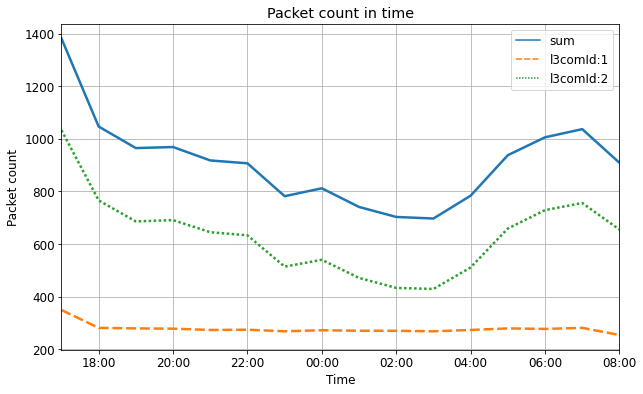

In [ ]:
col_name = 'l3comId'
tmpdf = df[list(filter(lambda x: col_name in x, df.columns))].copy()
tmpdf.insert(0,'sum',0)
# tmpdf['sum'] = tmpdf.apply(lambda row: , axis=1)
tmpdf['sum'] = tmpdf.sum(axis=1)
print(tmpdf)

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlabel('Time')
ax.set_ylabel('Packet count')
ax.set_title('Packet count in time')
ax.grid(True)

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

plt.xlim([min(tmpdf.index), max(tmpdf.index)])

sns.lineplot(data=tmpdf, palette="tab10", linewidth=2.5)
plt.show()

In [ ]:
a, b = datasetCreator.find_communication_pairs()

print(a)
print()
print(b)

bidict({1: CommunicationPair(src_ip='192.168.11.111', dst_ip='192.168.11.248', src_port=None, dst_port=None), 2: CommunicationPair(src_ip='192.168.11.248', dst_ip='192.168.11.111', src_port=None, dst_port=None)})

bidict({1: CommunicationPair(src_ip='192.168.11.111', dst_ip='192.168.11.248', src_port=56693, dst_port=2404), 2: CommunicationPair(src_ip='192.168.11.248', dst_ip='192.168.11.111', src_port=2404, dst_port=56693)})
